In [6]:
import tensorflow as tf
import numpy as np
import matplotlib as mpl
import IPython.display as display
import PIL.Image
import time

In [7]:
url = 'https://i.pinimg.com/564x/b8/6a/ff/b86affccebc50ca6228e94928f3931e4.jpg'
def download(url, max_dim=None):
    name = url.split('/')[-1]
    img_path = tf.keras.utils.get_file(name, origin=url)
    img = PIL.Image.open(img_path)
    if max_dim:
        img.thumbnail((max_dim, max_dim))
    return np.array(img)

def deprocess(img):
    return tf.cast(255 * (img + 1.0) / 2.0, tf.uint8)

def show(img):
    display.display(PIL.Image.fromarray(np.array(img)))

In [8]:
original_img = download(url, max_dim=500)

In [9]:
base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')
names = ['mixed3', 'mixed5']
layers = [base_model.get_layer(name).output for name in names]
dream_model = tf.keras.Model(inputs=base_model.input, outputs=layers)

In [10]:
def calculate_loss(img, model):
    img_batch = tf.expand_dims(img, 0)
    layer_activations = model(img_batch)
    losses = [tf.reduce_mean(activation) for activation in layer_activations]
    return tf.reduce_sum(losses)

In [11]:
class DeepDream(tf.Module):
    def __init__(self, model):
        self.model = model

    @tf.function(
        input_signature=(
            tf.TensorSpec(shape=[None, None, 3], dtype=tf.float32),
            tf.TensorSpec(shape=[], dtype=tf.int32),
            tf.TensorSpec(shape=[], dtype=tf.float32),
        )
    )
    def __call__(self, img, steps, step_size):
        loss = 0.0
        for _ in tf.range(steps):
            with tf.GradientTape() as tape:
                tape.watch(img)
                loss = calculate_loss(img, self.model)
            gradients = tape.gradient(loss, img)
            gradients /= tf.math.reduce_std(gradients) + 1e-8
            img += gradients * step_size
            img = tf.clip_by_value(img, -1, 1)

        return loss, img

In [12]:
deep_dream = DeepDream(dream_model)

In [13]:
def deep_dream_loop(img, steps=100, step_size=0.01):
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    img = tf.convert_to_tensor(img)
    step_size = tf.convert_to_tensor(step_size)

    while steps > 0:
        run_steps = tf.minimum(steps, 100)
        steps -= run_steps

        loss, img = deep_dream(img, run_steps, step_size)

        display.clear_output(wait=True)
        show(deprocess(img))

    result = deprocess(img)
    display.clear_output(wait=True)
    show(result)

    return result

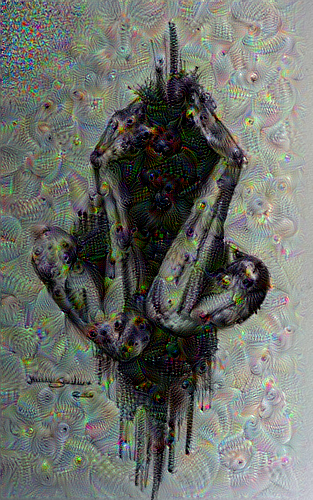

In [14]:
dream_img = deep_dream_loop(img = original_img, steps = 100, step_size = 0.01)

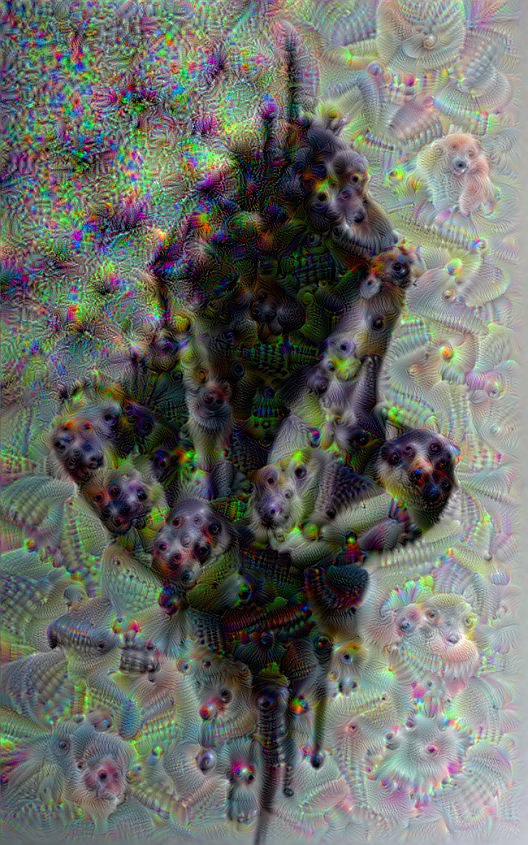

In [15]:
octave_scale = 1.30
img = tf.constant(np.array(original_img))
base_shape = tf.shape(img)[:-1]
float_base_shape = tf.cast(base_shape, tf.float32)

for n in range(-2, 3):
    new_shape = tf.cast(float_base_shape * (octave_scale ** n), tf.int32)
    img = tf.image.resize(img, new_shape).numpy()
    img = deep_dream_loop(img=img, steps=50, step_size=0.01)

display.clear_output(wait=True)
show(img)

In [16]:
def random_roll(img, maxroll):
    shift = tf.random.uniform([2], -maxroll, maxroll, dtype=tf.int32)
    img_rolled = tf.roll(img, shift, [0, 1])
    return shift, img_rolled

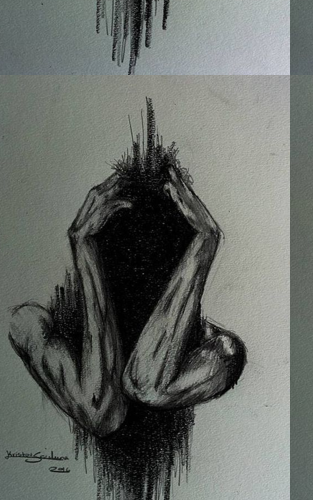

In [17]:
shift, img_rolled = random_roll(np.array(original_img), 512)
show(img_rolled)

In [18]:
class TiledGradients(tf.Module):
    def __init__(self, model):
        self.model = model

    @tf.function(
        input_signature=(
            tf.TensorSpec(shape=[None, None, 3], dtype=tf.float32),
            tf.TensorSpec(shape=[2], dtype=tf.int32),
            tf.TensorSpec(shape=[], dtype=tf.int32),
        )
    )
    def __call__(self, img, img_size, tile_size=512):
        shift, img_rolled = random_roll(img, tile_size)
        gradients = tf.zeros_like(img_rolled)

        xs = tf.range(0, img_size[1], tile_size)[:-1] or [0]
        ys = tf.range(0, img_size[0], tile_size)[:-1] or [0]

        for x in xs:
            for y in ys:
                with tf.GradientTape() as gradient_tape:
                    gradient_tape.watch(img_rolled)
                    img_tile = img_rolled[y:y + tile_size, x:x + tile_size]
                    loss = calculate_loss(img_tile, self.model)

                gradients += gradient_tape.gradient(loss, img_rolled)

        gradients = tf.roll(gradients, shift=-shift, axis=[0, 1])
        gradients /= tf.math.reduce_std(gradients) + 1e-8

        return gradients

In [19]:
get_tiled_gradients = TiledGradients(dream_model)